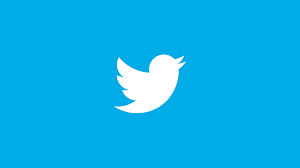

In [1]:
from IPython.display import Image
Image(filename="Unknown.png")

# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# Embedding

## Imports datas

In [3]:
# df will be used to train and evaluate the model
df = pd.read_csv('train.csv')
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
len_before = len(df)
df = df.drop_duplicates(subset = ['text'])
len_after = len(df)
print('we deleted', len_before - len_after, 'duplicates')

we deleted 110 duplicates


In [5]:
df.shape

(7503, 5)

In [6]:
#Example of NOT a disaster tweet

df[df["target"] == 0]["text"].values[1]

'I love fruits'

In [7]:
# Example of a disaster tweet

df[df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

## Clean / Preprocess the text

In [8]:
# Remove all non alphanumeric characters except whitespaces
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))


## Encode token as integer

In [9]:
df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization
# keeps only the most common words

tokenizer.fit_on_texts(df.text_clean)
# fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

# This step will effectively transform the texts into sequences of indices
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)


# Sometimes the preprocessing removes all the words in a string (because they contain
# only stopwords for example) so we calculate the length in order to filter out
# those records
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]


In [11]:
df.head()

,id,keyword,location,text,target,text_clean,text_encoded,len_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3614, 406, 175, 1663, 1901]",5
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[115, 3, 162, 505, 5444, 5445, 998]",7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1358, 440, 1664, 323, 5446, 284, 206, 1664, 3...",11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2268, 7, 2269, 68, 206, 295, 34]",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[269, 176, 121, 5447, 1665, 163, 68, 2270, 112]",9


## Padding

Adding zeros at the end or the beginning of each sentence in order for all sequences to be of the same length. <br>
=> to the end for our case

In [12]:
df_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")


In [13]:
df_pad

array([[3614,  406,  175, ...,    0,    0,    0],
       [ 115,    3,  162, ...,    0,    0,    0],
       [1358,  440, 1664, ...,    0,    0,    0],
       ...,
       [  42,  156,    9, ...,    0,    0,    0],
       [ 585,  921,  303, ...,    0,    0,    0],
       [ 103,   28,  348, ...,    0,    0,    0]], dtype=int32)

## Split

In [14]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(df_pad, df["target"], test_size=0.3)

# Turns dataframe into tensors
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Create random batches
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

## Model

In [15]:
embedding_dim=16 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])
model._name = "Word_Embedding"

model.summary()

Model: "Word_Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


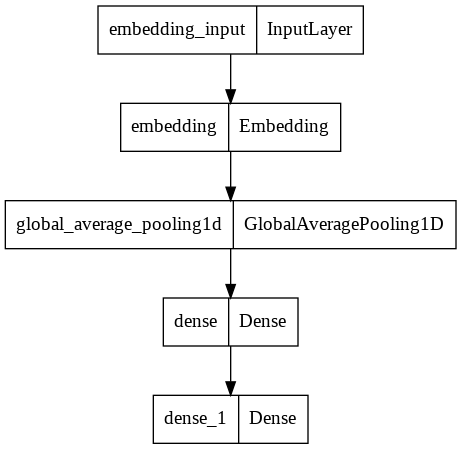

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True
)

In [17]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history_embedding = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=20)


Epoch 1/20
82/82 [==============================] - 1s 9ms/step - loss: 0.6822 - binary_accuracy: 0.5668 - val_loss: 0.6668 - val_binary_accuracy: 0.5899
Epoch 2/20
82/82 [==============================] - 0s 6ms/step - loss: 0.6639 - binary_accuracy: 0.5681 - val_loss: 0.6435 - val_binary_accuracy: 0.6033
Epoch 3/20
82/82 [==============================] - 0s 6ms/step - loss: 0.6208 - binary_accuracy: 0.6473 - val_loss: 0.5917 - val_binary_accuracy: 0.7084
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.5371 - binary_accuracy: 0.7735 - val_loss: 0.5265 - val_binary_accuracy: 0.8099
Epoch 5/20
82/82 [==============================] - 0s 6ms/step - loss: 0.4329 - binary_accuracy: 0.8508 - val_loss: 0.4609 - val_binary_accuracy: 0.8094
Epoch 6/20
82/82 [==============================] - 1s 6ms/step - loss: 0.3492 - binary_accuracy: 0.8756 - val_loss: 0.4411 - val_binary_accuracy: 0.8126
Epoch 7/20
82/82 [==============================] - 1s 6ms/step - loss: 0.29

## Perfs

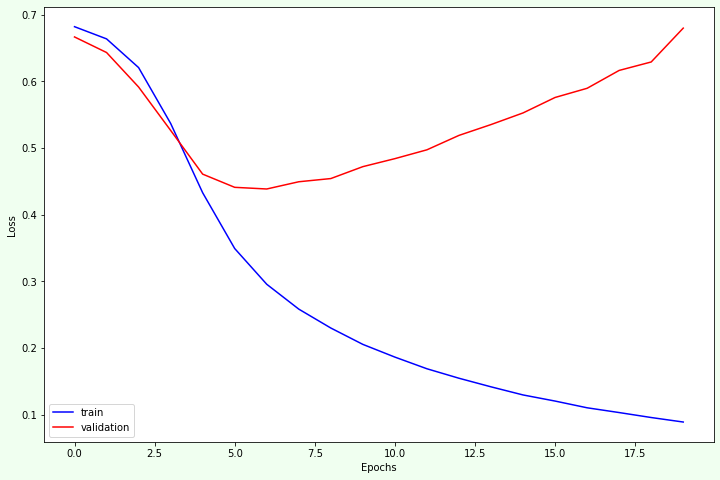

In [18]:
# Visualization of the training process on the loss function 
plt.figure(figsize=(12, 8), facecolor="honeydew")
plt.plot(history_embedding.history["loss"], color="b", label='train')
plt.plot(history_embedding.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


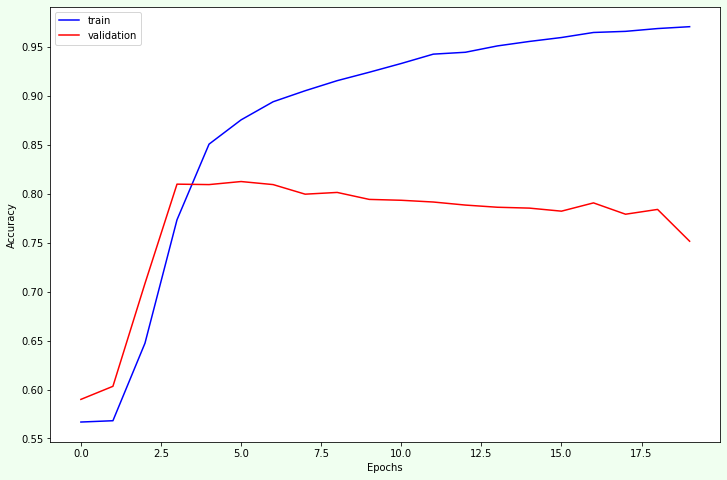

In [19]:
# Visualization of accuracy training 
plt.figure(figsize=(12, 8), facecolor="honeydew")
plt.plot(history_embedding.history["binary_accuracy"], color="b", label='train')
plt.plot(history_embedding.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend();


# Text Classification with RNN

## Import datas

In [20]:
# df will be used to train and evaluate the model
dataset = pd.read_csv('train.csv')
dataset = dataset.drop_duplicates(subset = ['text'])
#dataset = dataset.drop(['keyword', 'location'], axis=1)
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Pre processing

In [21]:
# Clean
dataset["text_clean"] = dataset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

# Encode
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.text_clean)
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text_clean)
dataset["len_text"] = dataset["text_encoded"].apply(lambda x: len(x))
dataset = dataset[dataset["len_text"]!=0]

# Pad
dataset_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")

# Tensor
full_ds = tf.data.Dataset.from_tensor_slices((dataset_pad, dataset.target.values))

# Split
TAKE_SIZE = int(0.7*dataset.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(32)

In [22]:
train_data.take(0)

<TakeDataset element_spec=(TensorSpec(shape=(None, 25), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## SimpleRNN


### Model

In [23]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model2 = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size + 1, 64, input_shape=[25,]),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(32, activation='relu'),
                  Dense(16, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and sigmoid activation
                  Dense(1, activation='sigmoid')
])
model2._name = "SimpleRNN"

In [24]:
model2.summary()

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            640064    
                                                                 
 simple_rnn (SimpleRNN)      (None, 25, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 653,025
Trainable params: 653,025
Non-train

In [25]:
model2.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [26]:
(dataset["target"]).value_counts()

0    4295
1    3191
Name: target, dtype: int64

### Weights to penalize too frequent evaluation

In [27]:
weights = 1/(dataset["target"]).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.8714784633294529, 1: 1.1729865246004387}

In [28]:
# Model training 
history_RNN = model2.fit(train_data,
          epochs=20, 
          validation_data=test_data,
          class_weight=weights)

Epoch 1/20
164/164 [==============================] - 7s 29ms/step - loss: 0.5917 - binary_accuracy: 0.6906 - val_loss: 0.5364 - val_binary_accuracy: 0.7373
Epoch 2/20
164/164 [==============================] - 4s 27ms/step - loss: 0.3770 - binary_accuracy: 0.8548 - val_loss: 0.5882 - val_binary_accuracy: 0.7351
Epoch 3/20
164/164 [==============================] - 4s 25ms/step - loss: 0.2703 - binary_accuracy: 0.9008 - val_loss: 0.6345 - val_binary_accuracy: 0.7386
Epoch 4/20
164/164 [==============================] - 4s 25ms/step - loss: 0.1796 - binary_accuracy: 0.9380 - val_loss: 0.6692 - val_binary_accuracy: 0.6968
Epoch 5/20
164/164 [==============================] - 5s 28ms/step - loss: 0.1101 - binary_accuracy: 0.9607 - val_loss: 0.8928 - val_binary_accuracy: 0.7226
Epoch 6/20
164/164 [==============================] - 4s 27ms/step - loss: 0.0911 - binary_accuracy: 0.9670 - val_loss: 0.9970 - val_binary_accuracy: 0.6776
Epoch 7/20
164/164 [==============================] - 4s 2

### Save

In [29]:
model.save("model_simpleRNN.h5")
import json
json.dump(model.history.history, open("simpleRNN_history.json", 'w'))

### Perfs

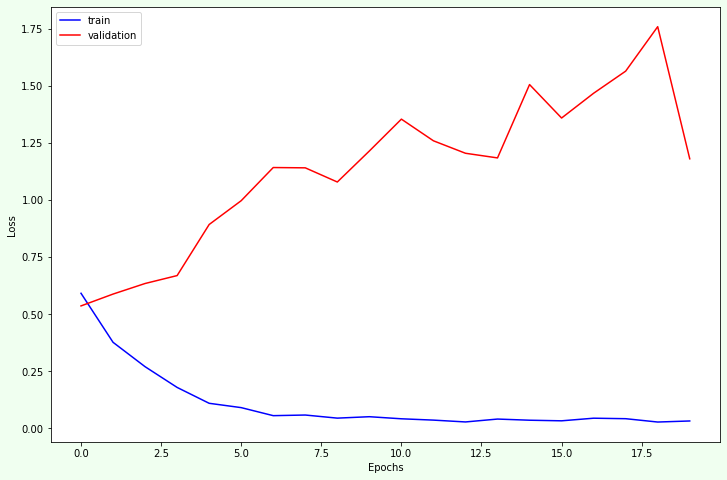

In [30]:
# Visualization of the training process on the loss function 
plt.figure(figsize=(12, 8), facecolor="honeydew")
plt.plot(history_RNN.history["loss"], color="b", label='train')
plt.plot(history_RNN.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


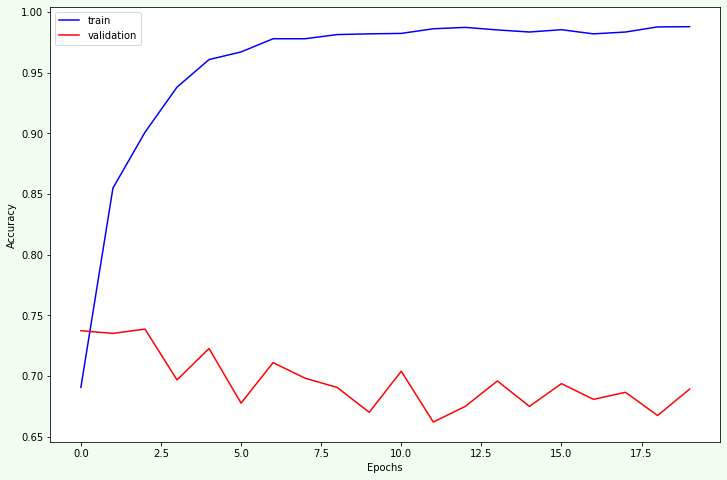

In [31]:
# Visualization of accuracy training 
plt.figure(figsize=(12, 8), facecolor="honeydew")
plt.plot(history_RNN.history["binary_accuracy"], color="b", label='train')
plt.plot(history_RNN.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend();


## GRU

In [32]:
from tensorflow.keras.layers import Embedding, Dense, GRU

model_gru = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size + 1, 64, input_shape=[25,]),
                  # Gobal average pooling
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(32, activation='relu'),
                  Dense(16, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and sigmoid activation
                  Dense(1, activation='sigmoid')
])
model_gru._name = "GRU"

model_gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 64)            640064    
                                                                 
 gru (GRU)                   (None, 25, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 676,033
Trainable params: 676,033
Non-trainable p

In [33]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [34]:
history_gru = model_gru.fit(train_data,
              epochs=20, 
              validation_data=test_data,
              class_weight=weights)

Epoch 1/20
164/164 [==============================] - 12s 50ms/step - loss: 0.6925 - binary_accuracy: 0.4899 - val_loss: 0.6925 - val_binary_accuracy: 0.5628
Epoch 2/20
164/164 [==============================] - 7s 43ms/step - loss: 0.6927 - binary_accuracy: 0.5252 - val_loss: 0.6959 - val_binary_accuracy: 0.4372
Epoch 3/20
164/164 [==============================] - 7s 43ms/step - loss: 0.6924 - binary_accuracy: 0.5374 - val_loss: 0.6936 - val_binary_accuracy: 0.4372
Epoch 4/20
164/164 [==============================] - 7s 45ms/step - loss: 0.6923 - binary_accuracy: 0.5624 - val_loss: 0.6916 - val_binary_accuracy: 0.5628
Epoch 5/20
164/164 [==============================] - 8s 46ms/step - loss: 0.6922 - binary_accuracy: 0.5561 - val_loss: 0.6918 - val_binary_accuracy: 0.5628
Epoch 6/20
164/164 [==============================] - 8s 50ms/step - loss: 0.6922 - binary_accuracy: 0.5784 - val_loss: 0.6918 - val_binary_accuracy: 0.5628
Epoch 7/20
164/164 [==============================] - 8s 

### Save

In [35]:
model_gru.save("model_gru.h5")
import json
json.dump(model_gru.history.history, open("GRU_history.json", 'w'))

## LSTM

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM

model_lstm = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size + 1, 64, input_shape=[25,]),
                  # Gobal average pooling
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(32, activation='relu'),
                  Dense(16, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and sigmoid activation
                  Dense(1, activation='sigmoid')
])
model_gru._name = "LSTM"

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 64)            640064    
                                                                 
 lstm (LSTM)                 (None, 25, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 687,105
Trainable params: 687,105
Non-tr

In [37]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [38]:
history_lstm = model_lstm.fit(train_data,
              epochs=20, 
              validation_data=test_data,
              class_weight=weights)

Epoch 1/20
164/164 [==============================] - 14s 54ms/step - loss: 0.5994 - binary_accuracy: 0.6477 - val_loss: 0.5031 - val_binary_accuracy: 0.7685
Epoch 2/20
164/164 [==============================] - 9s 55ms/step - loss: 0.3461 - binary_accuracy: 0.8643 - val_loss: 0.5194 - val_binary_accuracy: 0.7458
Epoch 3/20
164/164 [==============================] - 7s 43ms/step - loss: 0.2262 - binary_accuracy: 0.9195 - val_loss: 0.6267 - val_binary_accuracy: 0.7409
Epoch 4/20
164/164 [==============================] - 7s 45ms/step - loss: 0.1640 - binary_accuracy: 0.9481 - val_loss: 0.8246 - val_binary_accuracy: 0.7226
Epoch 5/20
164/164 [==============================] - 8s 48ms/step - loss: 0.1257 - binary_accuracy: 0.9641 - val_loss: 0.7347 - val_binary_accuracy: 0.7329
Epoch 6/20
164/164 [==============================] - 8s 46ms/step - loss: 0.1062 - binary_accuracy: 0.9695 - val_loss: 1.0254 - val_binary_accuracy: 0.6732
Epoch 7/20
164/164 [==============================] - 8s 

### Save

In [39]:
model_lstm.save("model_lstm.h5")
import json
json.dump(model_lstm.history.history, open("LSTM_history.json", 'w'))

## Classification Evaluation

### Simple RNN

In [40]:
tf.keras.utils.get_file("/content/model_simpleRNN.h5",
                        origin="/src/")

tf.keras.utils.get_file("/content/simpleRNN_history.json",
                        origin="/src")
simpleRNN_history = json.load(open("/content/simpleRNN_history.json", 'r'))
model_simpleRNN = tf.keras.models.load_model("/content/model_simpleRNN.h5")
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


### GRU

In [41]:
tf.keras.utils.get_file("/content/model_gru.h5", origin="/src/")

'/content/model_gru.h5'

In [42]:
tf.keras.utils.get_file("/content/GRU_history.json",
                        origin="/src/")

'/content/GRU_history.json'

In [43]:
GRU_history = json.load(open("/content/GRU_history.json", 'r'))
model_gru = tf.keras.models.load_model("/content/model_gru.h5")

In [44]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

### LSTM

In [45]:
tf.keras.utils.get_file("/content/model_lstm.h5",
                        origin="/src/")
tf.keras.utils.get_file("/content/LSTM_history.json",
                        origin="/src/")
LSTM_history = json.load(open("/content/LSTM_history.json", 'r'))
model_lstm = tf.keras.models.load_model("/content/model_lstm.h5")

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


# Conclusion

* All of our models aren't efficient
  * Embedding model and GRU model fail approximately at the 3rd epoch
  * LSTM fail immediately <br>
<br>
* Need to do a better preprocess on datas
* Need to train a pre trained model to do transfer learning or Word2Vec model for example.